In [29]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import gc

def remove_duplicates(lst):
    return list(dict.fromkeys(lst))

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# read csvs
train_log = pd.read_csv('../input/train_log.csv')
test_log = pd.read_csv('../input/test_log.csv')
log = pd.concat([train_log, test_log], axis=0)

del train_log, test_log
gc.collect()

# convert session_id to session_index
unique_ids = log['session_id'].unique()
session_index_map = {id:i for i, id in enumerate(unique_ids)}

log['session_index'] = log['session_id'].map(session_index_map)
log = log.drop('session_id', axis=1)

# 複数あるセッションのみを使用
log['session_length'] = log['session_index'].map(log.groupby('session_index').size().to_dict())
log = log.query('session_length > 1').reset_index(drop=True)

df = log[['session_index']].drop_duplicates().reset_index(drop=True)

In [30]:
# add history
log.sort_values(['session_index', 'seq_no'], ascending=[True, True], inplace=True)

history_map = defaultdict(list)
for session_index, group in tqdm(log.groupby('session_index')):
    history_map[session_index] = group['yad_no'].values.tolist()  # group is sorted by seq_no desc

df['histories'] = df['session_index'].map(history_map)

100%|██████████| 164072/164072 [00:05<00:00, 31498.39it/s]


In [31]:
from collections import Counter
from copy import deepcopy

def get_count_rank(counts):
    # 同一ランクを許すランキングを作成
    ranks = {}
    rank = 0
    previous_count = None

    for element, count in counts.most_common():
        # 同じ出現回数の場合は同じランクを割り当て
        if count != previous_count:
            rank = len(ranks)
            previous_count = count
        ranks[element] = rank

    return ranks

# Candidates from history

In [32]:
default_feats = {
    'session_index': -1,
    'yado_id': -1,
    'first_appeared_rank': -1,
    'last_appeared_rank': -1,
    'asc_rank0': False,
    'asc_rank1': False,
    'asc_rank2': False,
    'asc_rank3': False,
    'asc_rank4': False,
    'asc_rank5': False,
    'asc_rank6': False,
    'asc_rank7': False,
    'asc_rank8': False,
    'asc_rank9': False,
    'desc_rank0': False,
    'desc_rank1': False,
    'desc_rank2': False,
    'desc_rank3': False,
    'desc_rank4': False,
    'desc_rank5': False,
    'desc_rank6': False,
    'desc_rank7': False,
    'desc_rank8': False,
    'desc_rank9': False,
    'count': 0,
    'count_rank': -1,
    'num_seq': 0,
}

history_features = []
ignored_pairs = []
for session_index, histories in tqdm(df[['session_index', 'histories']].values):
    ignore_item = histories[-1]

    counts = Counter(histories)
    count_ranks = get_count_rank(counts)

    for history_index, yado_count in counts.items():
        if history_index == ignore_item:
            ignored_pairs.append((session_index, history_index))
            continue
        feats = deepcopy(default_feats)
        feats['session_index'] = session_index
        feats['yado_id'] = history_index
        feats['count'] = yado_count
        feats['count_rank'] = count_ranks[history_index]
        feats['num_seq'] = len(histories)
        yado_indices = [i for i, x in enumerate(histories) if x == history_index]
        for i in yado_indices:
            feats[f'asc_rank{i}'] = True
            feats[f'desc_rank{len(histories) - 1 - i}'] = True

        first_appeared_index = yado_indices[0]
        last_appeared_index = yado_indices[-1]
        feats['first_appeared_rank'] = first_appeared_index / len(histories)
        feats['last_appeared_rank'] = last_appeared_index / len(histories)
        history_features.append(feats)

history_df = pd.DataFrame(history_features)
print(history_df.shape)

100%|██████████| 164072/164072 [00:04<00:00, 36476.84it/s]


(172849, 27)


# Candidates from co-visit

In [33]:
co_visit_graph = defaultdict(lambda: defaultdict(int))

for session_index, group in tqdm(log.groupby('session_index')):
    yados = group['yad_no'].values
    for yado_id1 in yados:
        for yado_id2 in yados:
            if yado_id1 == yado_id2:
                continue
            co_visit_graph[yado_id1][yado_id2] += 1
            co_visit_graph[yado_id2][yado_id1] += 1

# sort by count
for history_index in co_visit_graph.keys():
    co_visit_graph[history_index] = sorted(co_visit_graph[history_index].items(), key=lambda x: x[1], reverse=True)

100%|██████████| 164072/164072 [00:06<00:00, 26924.28it/s]


In [34]:
import multiprocessing

def get_co_visit_candidates(yado_id, co_visit_graph):
    if len(co_visit_graph[yado_id]) == 0:
        return []
    return co_visit_graph[yado_id]

def process_session(session_index, history, co_visit_graph):
    first_history = history[0]
    last_history = history[-1]
    history = remove_duplicates(history)
    
    candidate_groups = defaultdict(list)
    for history_index in history:
        co_visit_candidates = get_co_visit_candidates(history_index, co_visit_graph)
        # co_visit_candidates = co_visit_candidates[:topk_co_visit_candidates]
        for candidate, count in co_visit_candidates:
            if candidate in history:
                continue
            candidate_groups[candidate].append((history_index, count))

    session_features = []
    for candidate_index, group in candidate_groups.items():
        connected_histories = set([x[0] for x in group])
        counts = [x[1] for x in group]
        
        feats = {}
        feats['session_index'] = session_index
        feats['yado_id'] = candidate_index
        feats['connect_with_last'] = last_history in connected_histories
        feats['connect_with_first'] = first_history in connected_histories
        feats['num_connect_history'] = len(connected_histories)
        feats['num_connect_history_allow_dup'] = len(group)
        feats['num_connect_history_ratio'] = len(connected_histories) / len(history)
        feats['num_connect_history_ratio_allow_dup'] = len(group) / len(history)
        feats['connect_count_sum'] = sum(counts)
        feats['connect_count_mean'] = feats['connect_count_sum'] / len(counts)
        feats['connect_count_max'] = max(counts)
        session_features.append(feats)

    return session_features

def process_sessions(data):
    session_index, history = data
    return process_session(session_index, history, co_visit_graph)

pool = multiprocessing.Pool()
results = pool.map(process_sessions, tqdm(df[['session_index', 'histories']].values))

all_co_visit_features = []
for session_features in results:
    all_co_visit_features.extend(session_features)

all_co_visit_df = pd.DataFrame(all_co_visit_features)

100%|██████████| 164072/164072 [00:05<00:00, 28556.42it/s]


# Merge

In [35]:
from utils import reduce_mem_usage

history_df = reduce_mem_usage(history_df)
all_co_visit_df = reduce_mem_usage(all_co_visit_df)

candidate_df = pd.concat([history_df, all_co_visit_df]).reset_index(drop=True)

Memory usage of dataframe is 12.53 MB
Memory usage after optimization is: 8.74 MB
Decreased by 30.3%
Memory usage of dataframe is 339.43 MB
Memory usage after optimization is: 100.91 MB
Decreased by 70.3%


# itemごとの特徴作成

In [36]:
yado_df = pd.read_csv('../input/yado.csv')
yado_df = yado_df.fillna(0)

# 閲覧回数
yado_df['yad_counts'] = yado_df['yad_no'].map(log['yad_no'].value_counts())

# セッション数
yado_df['session_counts'] = yado_df['yad_no'].map(log.groupby('yad_no')['session_index'].nunique())

area_cols = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']

# factorize
for col in area_cols:
    yado_df[col] = pd.factorize(yado_df[col])[0]

In [37]:
def get_co_visit_num(yado_id):
    return len(co_visit_graph[yado_id])

def get_co_visit_count(yado_id):
    if yado_id not in co_visit_graph.keys():
        return 0
    if not isinstance(co_visit_graph[yado_id], list):
        return 0
    return sum([count for _, count in co_visit_graph[yado_id]])

def get_co_visit_count_max(yado_id):
    if yado_id not in co_visit_graph.keys():
        return 0
    if not isinstance(co_visit_graph[yado_id], list):
        return 0
    return co_visit_graph[yado_id][0][1]

yado_df['co_visit_num'] = yado_df['yad_no'].map(get_co_visit_num)
yado_df['co_visit_count'] = yado_df['yad_no'].map(get_co_visit_count)
yado_df['co_visit_count_max'] = yado_df['yad_no'].map(get_co_visit_count_max)

In [38]:
# 地域情報
agg_cols = ['yad_counts', 'session_counts', 'total_room_cnt']
agg_funcs = ['mean', 'std', 'max', 'min']
area_cols = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']

for area_col in area_cols:
    # aggregate and merge
    area_df = yado_df.groupby(area_col)[agg_cols].agg(agg_funcs)
    area_df.columns = [area_col + '_' + '_'.join(col).strip() for col in area_df.columns.values]
    area_df = area_df.reset_index()
    yado_df = pd.merge(yado_df, area_df, on=area_col, how='left')

#diff from mean
for col in agg_cols:
    for area_col in area_cols:
        yado_df[col + '_diff'] = yado_df[col] - yado_df[area_col + '_' + col + '_mean']
        yado_df[col + '_ratio'] = yado_df[col] / yado_df[area_col + '_' + col + '_mean']

In [39]:
from utils import reduce_mem_usage

yado_df = yado_df.rename(columns={'yad_no': 'yado_id'})
yado_df = yado_df.fillna(0)
yado_df = reduce_mem_usage(yado_df)

candidate_df = candidate_df.merge(yado_df, on='yado_id', how='left')

Memory usage of dataframe is 7.69 MB
Memory usage after optimization is: 1.94 MB
Decreased by 74.8%


In [40]:
candidate_df = candidate_df.merge(df, on=['session_index'], how='left')

def get_same_history_area_count(history_areas, area):
    return sum([1 for history_area in history_areas if area == history_area])

for area_col in area_cols:
    print(area_col)
    area_map = yado_df[['yado_id', area_col]].set_index('yado_id')[area_col].to_dict()
    candidate_df['history_' + area_col] = candidate_df['histories'].map(lambda histories: [area_map[yado_id] for yado_id in set(histories)])

    candidate_df[area_col] = candidate_df['yado_id'].map(area_map)

    history_area = candidate_df['history_' + area_col].values
    yado_area = candidate_df[area_col].values
    counts = []
    ratios = []
    for i in tqdm(range(len(history_area))):
        count = get_same_history_area_count(history_area[i], yado_area[i])
        ratio = count / len(history_area[i])
        counts.append(count)
        ratios.append(ratio)
    candidate_df['same_history_' + area_col + '_count'] = counts
    candidate_df['same_history_' + area_col + '_ratio'] = ratios

wid_cd


100%|██████████| 4982492/4982492 [00:05<00:00, 903932.94it/s]


ken_cd


100%|██████████| 4982492/4982492 [00:05<00:00, 916780.27it/s]


lrg_cd


100%|██████████| 4982492/4982492 [00:05<00:00, 930333.96it/s]


sml_cd


100%|██████████| 4982492/4982492 [00:05<00:00, 940442.28it/s]


In [41]:
drop_cols = [
 'histories',
 'history_wid_cd',
 'history_ken_cd',
 'history_lrg_cd',
 'history_sml_cd',
]

candidate_df = candidate_df.drop(drop_cols, axis=1)

gc.collect()

0

In [42]:
train_labels = pd.read_csv('../input/train_label.csv')
train_labels = train_labels.rename(columns={'yad_no': 'yado_id'})
train_labels['session_index'] = train_labels['session_id'].map(session_index_map)
train_labels = train_labels.drop('session_id', axis=1)
train_labels['label'] = 1

candidate_df = candidate_df.merge(train_labels, on=['session_index', 'yado_id'], how='left')
candidate_df['label'] = candidate_df['label'].fillna(0)

candidate_df['is_train'] = candidate_df['session_index'].isin(train_labels['session_index'].unique())
candidate_df.loc[~candidate_df['is_train'], 'label'] = -1

In [43]:
train_df = candidate_df.query('is_train == True').reset_index(drop=True)
test_df = candidate_df.query('is_train == False').reset_index(drop=True)

In [44]:
# add groupkfold by session_index
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)
train_df['fold'] = -1

for fold, (train_index, valid_index) in enumerate(group_kfold.split(train_df, train_df['label'], train_df['session_index'])):
    train_df.loc[valid_index, 'fold'] = fold

In [45]:
import lightgbm as lgb

def lgb_train(train_df, fold, test_df=None):

    except_cols = [
        "session_index",
        "yado_id",
        "label",
        "fold",
        "is_train",
        "oof_pred"
    ]

    use_feats = [c for c in train_df.columns if c not in except_cols]
    print(f"feature length: {len(use_feats)}")

    rank_params = {
        'seed': 2020,
        'objective': 'lambdarank',
        'metric': 'map',
        'verbosity': -1,
        'learning_rate': 0.01,
        'ndcg_eval_at': [10],
    }

    target_col = "label"

    _train_df = train_df.loc[train_df['fold'] != fold].reset_index(drop=True)
    _valid_df = train_df.loc[train_df['fold'] == fold].reset_index(drop=True)

    _train_df = _train_df.sort_values("session_index").reset_index(drop=True)
    _valid_df = _valid_df.sort_values("session_index").reset_index(drop=True)

    print(f"train: {_train_df.shape}")
    print(f"valid: {_valid_df.shape}")

    _train_df_group_id = _train_df.groupby("session_index").size().values
    _valid_df_group_id = _valid_df.groupby("session_index").size().values

    train_data = lgb.Dataset(
        _train_df[use_feats],
        label=_train_df[target_col],
        group=_train_df_group_id
    )
    valid_data = lgb.Dataset(
        _valid_df[use_feats],
        label=_valid_df[target_col],
        group=_valid_df_group_id
    )

    model = lgb.train(
        train_set=train_data,
        params=rank_params,
        valid_sets=[train_data, valid_data],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
                   lgb.log_evaluation(25)]
    )

    imp_df = pd.DataFrame({
        "feature": use_feats,
        "gain": model.feature_importance(importance_type="gain")
    })
    imp_df = imp_df.sort_values("gain", ascending=False)

    # oof
    train_df.loc[train_df['fold'] == fold, 'oof_pred'] = model.predict(train_df.loc[train_df['fold'] == fold, use_feats])

    test_df = test_df.sort_values("session_index").reset_index(drop=True)
    test_df[f'pred_fold{fold}'] = model.predict(test_df[use_feats])
    return model, imp_df, use_feats, train_df, test_df

# visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_importance(imp_df):
    plt.figure(figsize=(10, 5))
    sns.barplot(x="gain", y="feature", data=imp_df[:20])
    plt.tight_layout()
    plt.show()

feature length: 113
train: (2650528, 119)
valid: (662632, 119)
Training until validation scores don't improve for 100 rounds
[25]	training's map@10: 0.887125	valid_1's map@10: 0.886982
[50]	training's map@10: 0.887321	valid_1's map@10: 0.88713
[75]	training's map@10: 0.887429	valid_1's map@10: 0.887305
[100]	training's map@10: 0.887507	valid_1's map@10: 0.887233
[125]	training's map@10: 0.887596	valid_1's map@10: 0.8874
[150]	training's map@10: 0.887677	valid_1's map@10: 0.887412
[175]	training's map@10: 0.887803	valid_1's map@10: 0.887511
[200]	training's map@10: 0.887804	valid_1's map@10: 0.88752
[225]	training's map@10: 0.88789	valid_1's map@10: 0.887505
[250]	training's map@10: 0.88807	valid_1's map@10: 0.88759
[275]	training's map@10: 0.888206	valid_1's map@10: 0.887846
[300]	training's map@10: 0.88834	valid_1's map@10: 0.887965
[325]	training's map@10: 0.888437	valid_1's map@10: 0.888007
[350]	training's map@10: 0.888527	valid_1's map@10: 0.887983
[375]	training's map@10: 0.88868

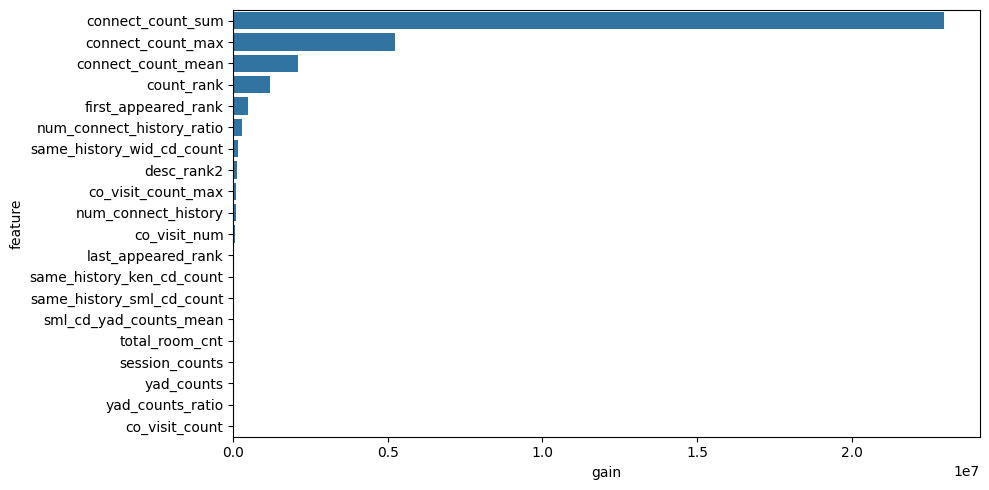

feature length: 113
train: (2650528, 119)
valid: (662632, 119)
Training until validation scores don't improve for 100 rounds
[25]	training's map@10: 0.887139	valid_1's map@10: 0.886849
[50]	training's map@10: 0.887301	valid_1's map@10: 0.886995
[75]	training's map@10: 0.887476	valid_1's map@10: 0.886932
[100]	training's map@10: 0.88745	valid_1's map@10: 0.887061
[125]	training's map@10: 0.887589	valid_1's map@10: 0.887038
[150]	training's map@10: 0.887675	valid_1's map@10: 0.887151
[175]	training's map@10: 0.887757	valid_1's map@10: 0.887083
[200]	training's map@10: 0.887799	valid_1's map@10: 0.887128
[225]	training's map@10: 0.888123	valid_1's map@10: 0.887228
[250]	training's map@10: 0.888251	valid_1's map@10: 0.8873
[275]	training's map@10: 0.888382	valid_1's map@10: 0.887313
[300]	training's map@10: 0.888523	valid_1's map@10: 0.887309
[325]	training's map@10: 0.888659	valid_1's map@10: 0.887307
[350]	training's map@10: 0.888829	valid_1's map@10: 0.887226
Early stopping, best iterat

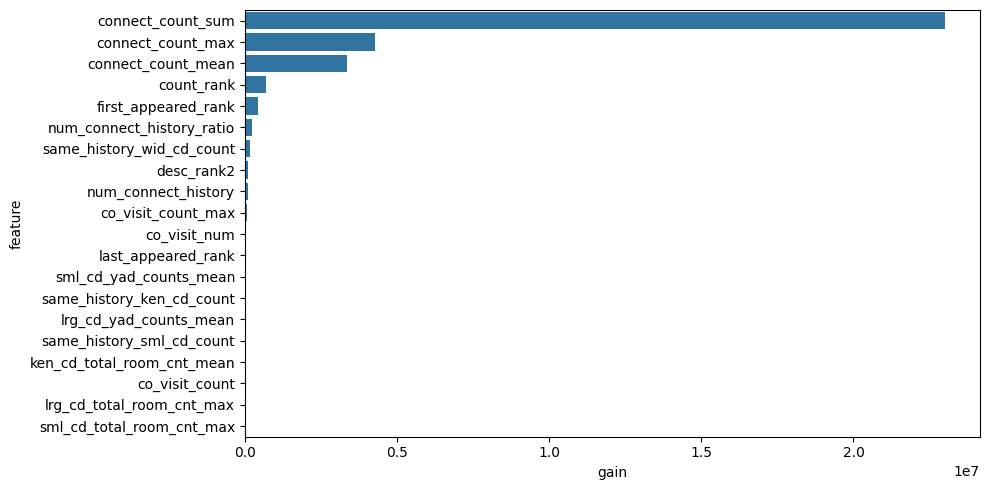

feature length: 113
train: (2650528, 119)
valid: (662632, 119)
Training until validation scores don't improve for 100 rounds
[25]	training's map@10: 0.887642	valid_1's map@10: 0.884486
[50]	training's map@10: 0.88787	valid_1's map@10: 0.88461
[75]	training's map@10: 0.888097	valid_1's map@10: 0.884768
[100]	training's map@10: 0.88816	valid_1's map@10: 0.884755
[125]	training's map@10: 0.888259	valid_1's map@10: 0.88489
[150]	training's map@10: 0.888301	valid_1's map@10: 0.884945
[175]	training's map@10: 0.888321	valid_1's map@10: 0.884928
[200]	training's map@10: 0.888406	valid_1's map@10: 0.884948
[225]	training's map@10: 0.888446	valid_1's map@10: 0.885021
[250]	training's map@10: 0.888708	valid_1's map@10: 0.885136
[275]	training's map@10: 0.888798	valid_1's map@10: 0.885231
[300]	training's map@10: 0.888934	valid_1's map@10: 0.885445
[325]	training's map@10: 0.88905	valid_1's map@10: 0.885493
[350]	training's map@10: 0.889194	valid_1's map@10: 0.885666
[375]	training's map@10: 0.88

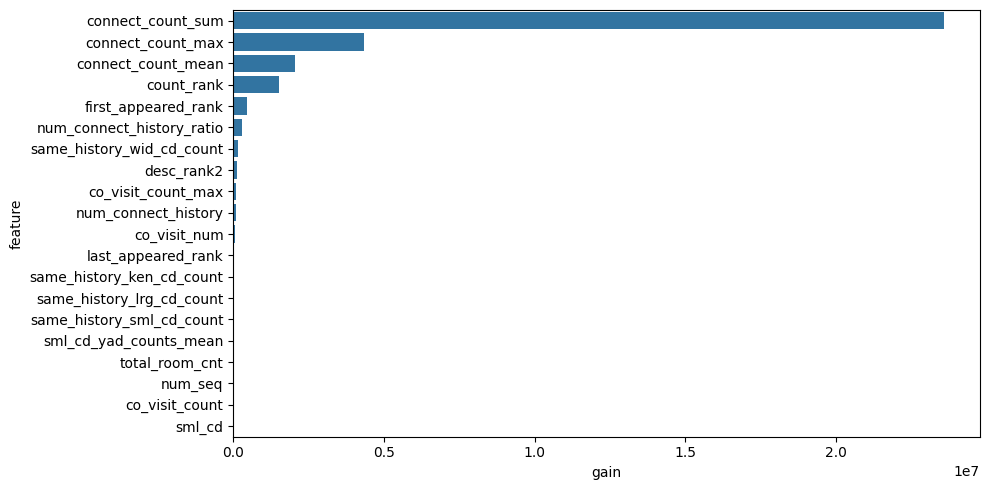

feature length: 113
train: (2650528, 119)
valid: (662632, 119)
Training until validation scores don't improve for 100 rounds
[25]	training's map@10: 0.886446	valid_1's map@10: 0.889544
[50]	training's map@10: 0.886637	valid_1's map@10: 0.889703
[75]	training's map@10: 0.88681	valid_1's map@10: 0.889706
[100]	training's map@10: 0.88684	valid_1's map@10: 0.889762
[125]	training's map@10: 0.886989	valid_1's map@10: 0.889901
[150]	training's map@10: 0.887066	valid_1's map@10: 0.889961
[175]	training's map@10: 0.887119	valid_1's map@10: 0.889955
[200]	training's map@10: 0.887195	valid_1's map@10: 0.889972
[225]	training's map@10: 0.887384	valid_1's map@10: 0.889973
[250]	training's map@10: 0.887512	valid_1's map@10: 0.890013
[275]	training's map@10: 0.887646	valid_1's map@10: 0.890178
[300]	training's map@10: 0.887682	valid_1's map@10: 0.890184
[325]	training's map@10: 0.887792	valid_1's map@10: 0.890172
[350]	training's map@10: 0.887898	valid_1's map@10: 0.890294
[375]	training's map@10: 0

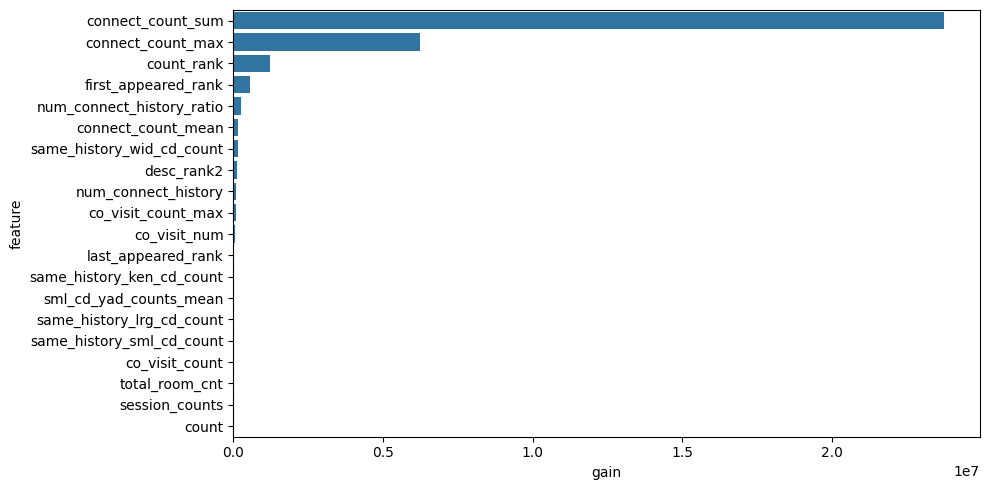

feature length: 113
train: (2650528, 119)
valid: (662632, 119)
Training until validation scores don't improve for 100 rounds
[25]	training's map@10: 0.887324	valid_1's map@10: 0.885784
[50]	training's map@10: 0.887485	valid_1's map@10: 0.88586
[75]	training's map@10: 0.887679	valid_1's map@10: 0.886002
[100]	training's map@10: 0.887769	valid_1's map@10: 0.886125
[125]	training's map@10: 0.887873	valid_1's map@10: 0.886168
[150]	training's map@10: 0.887982	valid_1's map@10: 0.886185
[175]	training's map@10: 0.888056	valid_1's map@10: 0.886255
[200]	training's map@10: 0.88809	valid_1's map@10: 0.886363
[225]	training's map@10: 0.888174	valid_1's map@10: 0.886361
[250]	training's map@10: 0.888509	valid_1's map@10: 0.886549
[275]	training's map@10: 0.888651	valid_1's map@10: 0.886449
[300]	training's map@10: 0.88874	valid_1's map@10: 0.886466
[325]	training's map@10: 0.888826	valid_1's map@10: 0.886552
[350]	training's map@10: 0.88902	valid_1's map@10: 0.886599
[375]	training's map@10: 0.8

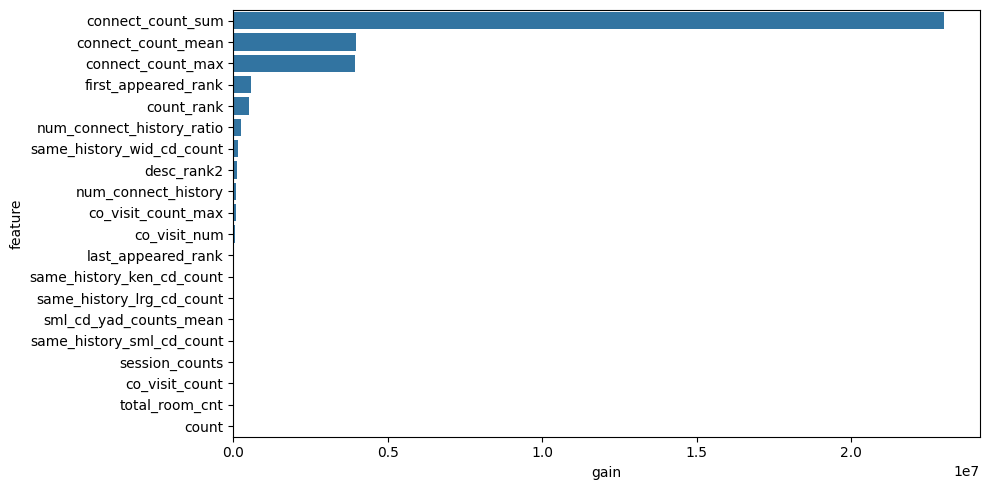

In [46]:
train_df['oof_pred'] = -1

for fold in range(5):
    model, imp_df, use_feats, train_df, test_df = lgb_train(train_df, fold, test_df)
    visualize_importance(imp_df)
    # save
    model.save_model(f'output/model_fold{fold}.txt')
    imp_df.to_csv(f'output/imp_fold{fold}.csv', index=False)

In [47]:
# oof
for fold in range(5):
    model = lgb.Booster(model_file=f'output/model_fold{fold}.txt')
    train_df.loc[train_df['fold'] == fold, 'oof_pred'] = model.predict(train_df.loc[train_df['fold'] == fold, use_feats])

In [48]:
train_df['pred_rank'] = train_df.groupby('session_index')['oof_pred'].rank(ascending=False, method='first')
train_df['pred_rank'] = train_df['pred_rank'].astype(int)
train_top10_df = train_df.query('pred_rank <= 10').reset_index(drop=True)
train_top10_df = train_top10_df.sort_values(['session_index', 'pred_rank']).reset_index(drop=True)

session_indices = train_df['session_index'].unique()

train_labels = pd.read_csv("../input/train_label.csv")
train_labels['session_index'] = train_labels['session_id'].map(session_index_map)
train_labels = train_labels[train_labels['session_index'].isin(session_indices)]
train_labels.rename(columns={'yad_no': 'label'}, inplace=True)

candidates = {}
for session_index, group in train_top10_df.groupby('session_index'):
    candidates[session_index] = list(group['yado_id'].values)

train_labels['candidates'] = train_labels['session_index'].map(candidates)

In [50]:
from metric import apk

def calc_mapk(df, col='candidates', k=10):
    df['score'] = [apk(a, p, k) for a, p in zip(df['label'].values, df[col].values)]
    return df['score'].mean()

def calc_recall(df, col='candidates', topk=10):
    df['in_candidates'] = df.apply(lambda x: x['label'] in x[col][:topk], axis=1)
    return df['in_candidates'].sum() / len(df)

def eval_candidates(df, candidate_cols, eval_for_single_history=True, eval_for_multi_history=True, show_hist=False):
    print("*"*100)
    print('candidate_cols:', candidate_cols)
    
    df['temp_candidates'] = [[]] * len(df)
    for col in candidate_cols:
        df['temp_candidates'] += df[col]
    
    df['temp_candidates'] = df['temp_candidates'].map(remove_duplicates)

    # トータルのrecall
    print("mapk:", calc_mapk(df, col='temp_candidates'))
    print("recall @10:", calc_recall(df, col='temp_candidates', topk=10))

    # 候補数
    print("num average candidates:", df['temp_candidates'].map(len).mean())
    print("num total candidates:", df['temp_candidates'].map(len).sum())
    if show_hist:
        _ = df['temp_candidates'].map(lambda x: len(set(x))).hist(bins=10)
    
    df = df.drop('temp_candidates', axis=1)

eval_candidates(train_labels, ['candidates'])

# ****************************************************************************************************
# candidate_cols: ['candidates']
# mapk: 0.8873750433269173
# recall @10: 0.9905335295028651
# num average candidates: 9.683202338547312
# num total candidates: 1000391

****************************************************************************************************
candidate_cols: ['candidates']
mapk: 0.8876176971098181
recall @10: 0.9908045531980796
num average candidates: 9.683202338547312
num total candidates: 1000391


In [51]:
test_df['pred'] = test_df[[f'pred_fold{i}' for i in range(5)]].mean(axis=1)

test_df['pred_rank'] = test_df.groupby('session_index')['pred'].rank(ascending=False, method='first')
test_df['pred_rank'] = test_df['pred_rank'].astype(int)

test_df = test_df[['session_index', 'yado_id', 'pred_rank']]
test_df = test_df.sort_values(['session_index', 'pred_rank'])

In [64]:
session_indices = []
pred_candidates = []
for session_index, group in test_df.groupby('session_index'):
    session_indices.append(session_index)
    pred_candidates.append(group['yado_id'].tolist())

test_pred_df = pd.DataFrame({
    'session_index': session_indices,
    'candidates': pred_candidates
})

test_pred_df.to_pickle('output/test_pred_df_re_rank.pkl')

In [ ]:
v010 = pd.read_pickle('./output/test_df_v010.pkl')
v010 = v010[['session_index', 'candidates']]

v004 = pd.read_csv('test_pred_df_v004.csv')

In [ ]:
v004 = v004.sort_values(['session_index', 'pred_rank'])

pred_candidates = []
for session_index, group in v004.groupby('session_index'):
    pred_candidates.append(group['yado_id'].tolist())

In [ ]:
multi_sessioin_index = v004['session_index'].unique().tolist()

In [ ]:
multi_v010 = v010[v010['session_index'].isin(multi_sessioin_index)]
multi_v010['candidates_v004'] = pred_candidates
multi_v010.rename(columns={'candidates': 'candidates_v010'}, inplace=True)

single_v010 = v010[~v010['session_index'].isin(multi_sessioin_index)]

In [ ]:
tqdm.pandas()

def ensemble(row, candidate_cols, weights):
    assert len(candidate_cols) == len(weights)

    res = defaultdict(float)
    for col, weight in zip(candidate_cols, weights):
        for n, item in enumerate(row[col], start=1):
            res[item] += weight / n
    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

    return res       

In [ ]:
cols = ['candidates_v010', 'candidates_v004']
weights = [0.49, 0.51]
multi_v010['candidates'] = multi_v010.progress_apply(lambda x: ensemble(x, cols, weights), axis=1)

In [ ]:
cols = ['session_index', 'candidates']
v010 = pd.concat([single_v010[cols], multi_v010[cols]]).reset_index(drop=True)
v010.sort_values('session_index', inplace=True)
v010 = v010.reset_index(drop=True)

In [ ]:
# sub
sub = pd.read_csv('../input/sample_submission.csv')
for i in range(10):
    sub[f'predict_{i}'] = v010['candidates'].map(lambda x: x[i] if len(x) > i else -1)

sub.to_csv('output/sub_v010_v004.csv', index=False)
sub.head(10)